## 캐글 데이터

- 데이터 셋 : https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset/data

- 출처 : https://www.kaggle.com/code/qqerladnwls132/resnet50-fine-tuning-85/edit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,767 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123605 files and dire

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}

In [ ]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

## 데이터 셋 생성

In [ ]:
import zipfile
import os

# 압축 파일 경로
zip_path = '/content/drive/MyDrive/대구은행/자유주제_피부_프로젝트/archive.zip'

# 압축을 풀 폴더 경로
extract_path = './'

# 압축 풀기
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 압축이 풀린 파일 목록 확인
os.listdir(extract_path)

['.config', 'Oily-Dry-Skin-Types', 'drive', 'sample_data']

In [ ]:
train_df = create_df("/content/Oily-Dry-Skin-Types/train")
val_df = create_df("/content/Oily-Dry-Skin-Types/valid")
test_df = create_df("/content/Oily-Dry-Skin-Types/test")

In [ ]:
train_df = pd.concat([train_df, val_df, test_df])

## 훈련 파라미터 정의

In [ ]:
EPOCHS = 20 # 에폭 20
LR = 0.1    # 학습률 0.1
STEP = 15   # 스텝 사이즈(Step size). 일정 횟수의 epoch마다 학습률을 감소시키기 위한 기준이 되는 epoch 수.
GAMMA = 0.1 # 감마(Gamma). 학습률을 감소시킬 때 곱해지는 비율. STEP 주기마다 학습률에 GAMMA를 곱해 학습률을 줄임.
BATCH = 32
OUT_CLASSES = 3
IMG_SIZE = 224

In [ ]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))

        return img, label

In [ ]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomVerticalFlip(0.6),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

In [ ]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

In [ ]:
train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

## ResNet50 세팅

In [ ]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2) # 전이학습
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 123MB/s]


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## 훈련 툴

In [ ]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR) # SGD -> ADAM 만듬 Adam 별로
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [ ]:
# Early Stopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")

Training

In [ ]:
from copy import deepcopy
import torch
import pandas as pd
from torch.utils.data import WeightedRandomSampler

# #----------------------WeightRandomsample--------------------------------------
# # 레이블에 따른 샘플 수 계산
# class_counts = train_df.iloc[:, 1].value_counts()  # assuming second column contains labels
# class_weights = 1. / class_counts
# sample_weights = class_weights[train_df.iloc[:, 1]].values

# # WeightedRandomSampler 정의
# weighted_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# # 데이터 로더 생성 시 sampler를 추가
# train_dl = DataLoader(train_ds, batch_size=BATCH, sampler=weighted_sampler)
# val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)
# #---------------------------------------------------------------

# 훈련 루프
# early_stopping = EarlyStopping(patience=5, verbose=True)

best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()

    diff = 0
    total = 0
    acc = 0

    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()

    train_loss += [diff/total]
    train_acc += [acc/total]

    model.eval()

    diff = 0
    total = 0
    acc = 0

    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    val_loss += [diff/total]
    val_acc += [acc/total]

    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    scheduler.step()

    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                    train_acc[-1], val_loss[-1],
                                                                    val_acc[-1]))

# # 최종 모델 저장
torch.save(best_model.state_dict(), "얼굴타입모델.pth")
print("최종 모델이 얼굴타입모델.pth로 저장되었습니다.")

Epochs 1 train loss 0.046782609750618306 acc 0.4418881396271321 val loss 0.056871836147611106 acc 0.3682539682539683
Epochs 2 train loss 0.02664256171544645 acc 0.6386354621182071 val loss 0.04727283394525922 acc 0.3968253968253968
Epochs 3 train loss 0.016798665390181097 acc 0.7810392701309005 val loss 0.0353338983323839 acc 0.5777777777777777
Epochs 4 train loss 0.011826996512353444 acc 0.859579531931773 val loss 0.0363083457189893 acc 0.5492063492063493
Epochs 5 train loss 0.008170591412390665 acc 0.9012296707655693 val loss 0.040564057562086316 acc 0.580952380952381
Epochs 6 train loss 0.006699333882837814 acc 0.9218564061880207 val loss 0.025710011285448833 acc 0.7428571428571429
Epochs 7 train loss 0.003433066210792633 acc 0.9674732249107497 val loss 0.024700874090194704 acc 0.765079365079365
Epochs 8 train loss 0.002298650909946675 acc 0.9769932566441888 val loss 0.03157861384134444 acc 0.7936507936507936
Epochs 9 train loss 0.002237556308643868 acc 0.9754065846886156 val loss 0

모델 퍼포먼스

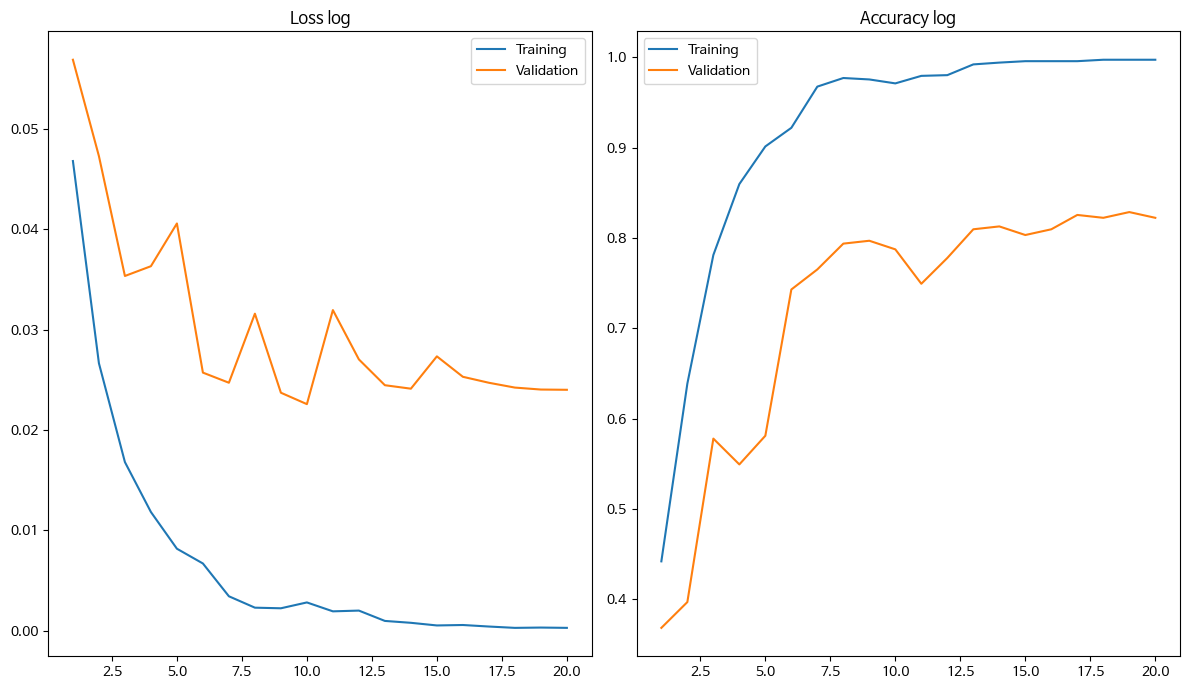

In [ ]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

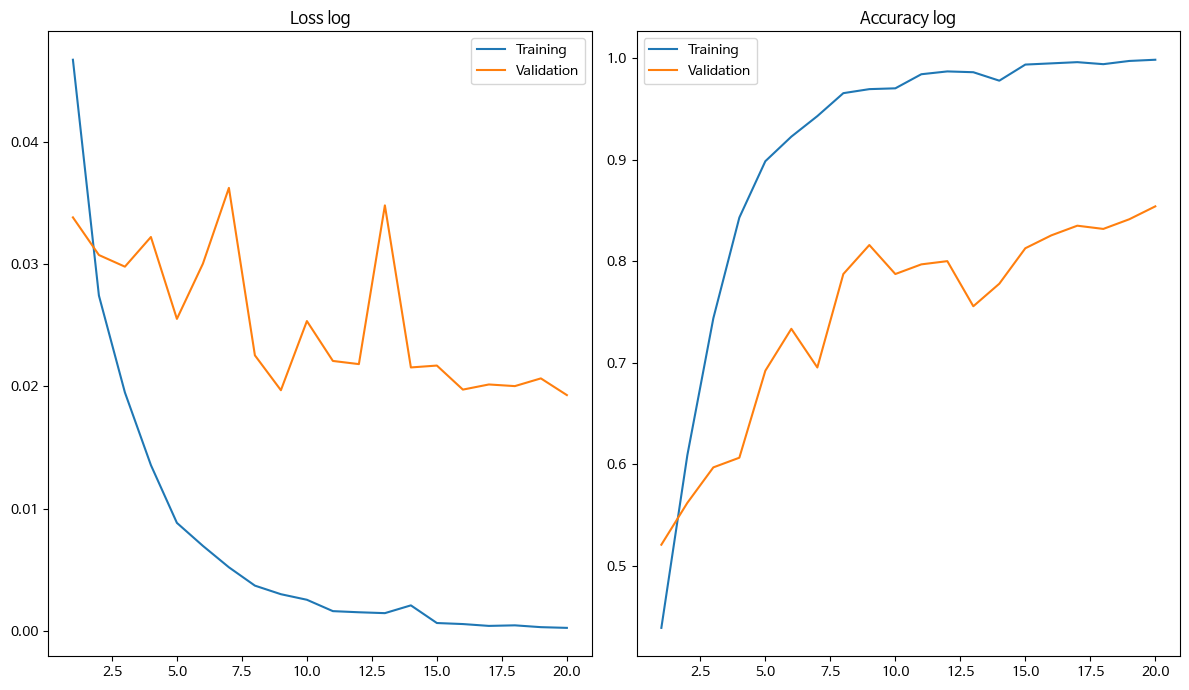

In [ ]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

In [ ]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()

        out = best_model(img)

        return out.argmax(1).item()

In [ ]:
pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

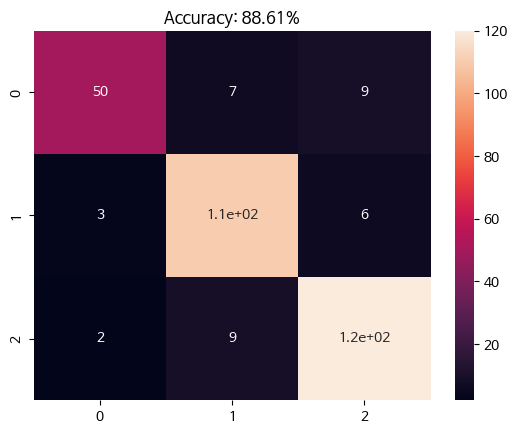

In [ ]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

파랑색 히트맵

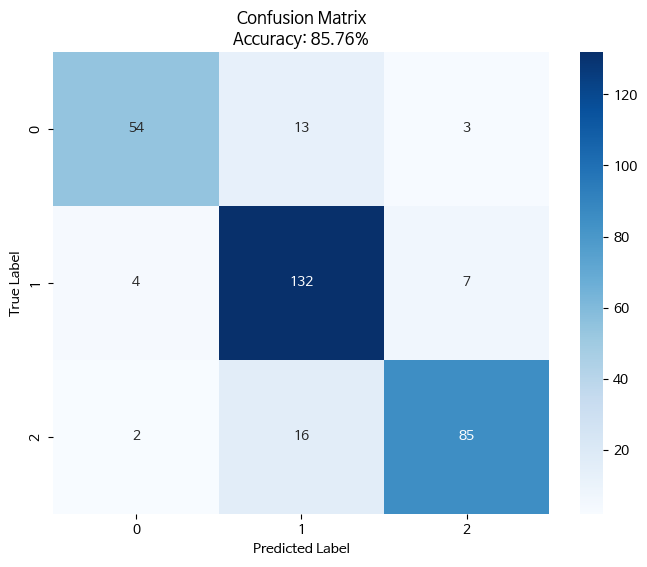

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# 예측 및 진실값으로 혼동 행렬 계산
cm = confusion_matrix(truth, pred)

# 정확도 계산
score = accuracy_score(truth, pred)

# 혼동 행렬을 파란색 계열로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # 파란색 계열의 'Blues' 컬러맵 사용
plt.title("Confusion Matrix\nAccuracy: {}%".format(round(score * 100, 2)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 시각화 출력
plt.show()


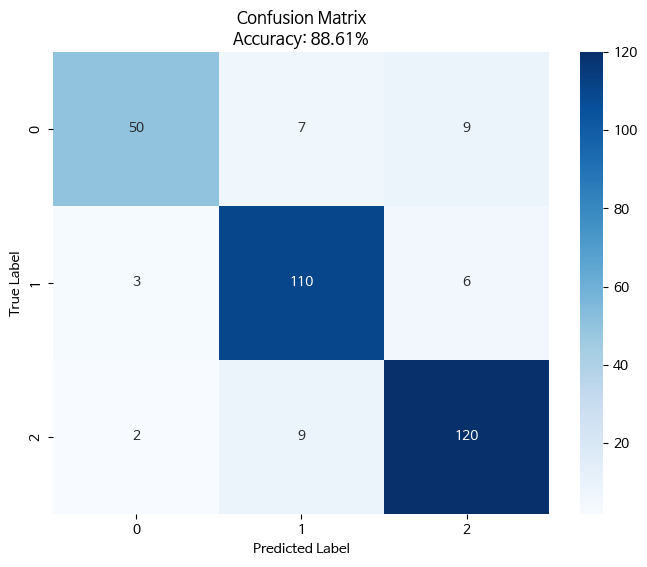

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# 예측 및 진실값으로 혼동 행렬 계산
cm = confusion_matrix(truth, pred)

# 정확도 계산
score = accuracy_score(truth, pred)

# 혼동 행렬을 파란색 계열로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # 파란색 계열의 'Blues' 컬러맵 사용
plt.title("Confusion Matrix\nAccuracy: {}%".format(round(score * 100, 2)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 시각화 출력
plt.show()


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.91      0.76      0.83        66
           1       0.87      0.92      0.90       119
           2       0.89      0.92      0.90       131

    accuracy                           0.89       316
   macro avg       0.89      0.87      0.88       316
weighted avg       0.89      0.89      0.88       316



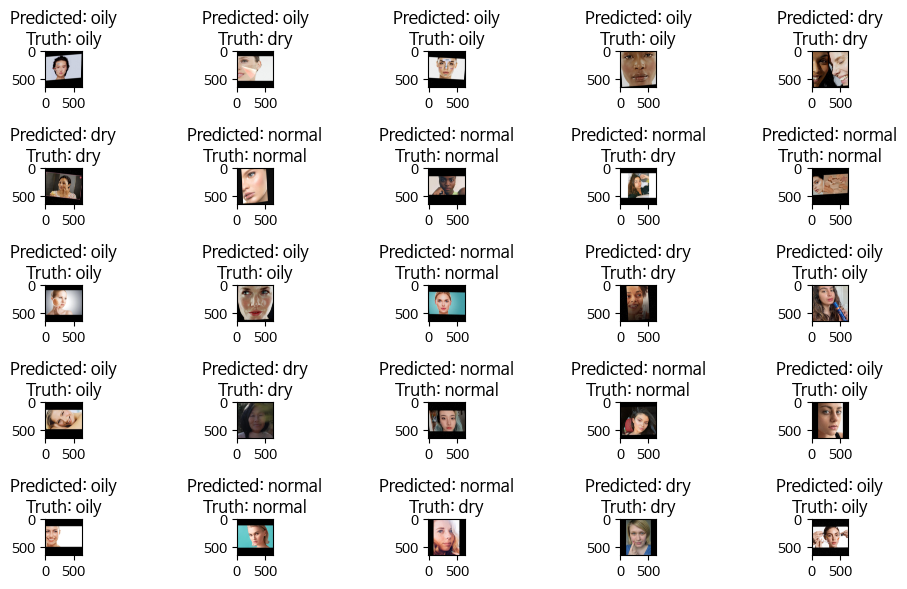

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1

plt.tight_layout()
plt.show()

"dry": 0, "normal": 1, "oily": 2

In [83]:
import torch
from torchvision import transforms
from torchvision.models import resnet50
from PIL import Image

# 전처리 정의
IMG_SIZE = 224  # 모델의 입력 크기에 맞게 설정
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 모델 불러오기
model_path = '/content/drive/MyDrive/대구은행/자유주제_피부_프로젝트/얼굴타입모델_85.pth'
model = resnet50(weights='IMAGENET1K_V2')  # Pretrained weights를 사용하여 모델 생성
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)  # OUT_CLASSES 수에 맞게 레이어 변경

# 모델 가중치 로드 (마지막 레이어 제외)
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
# 마지막 레이어를 제외한 가중치만 로드
state_dict = {k: v for k, v in state_dict.items() if not k.startswith('fc.')}
model.load_state_dict(state_dict, strict=False)  # 마지막 레이어는 로드하지 않도록 설정
model.eval()  # 평가 모드로 설정

# 이미지 불러오기
image_path = '/content/drive/MyDrive/대구은행/자유주제_피부_프로젝트/증명사진.jpg'
image = Image.open(image_path).convert('RGB')  # 이미지를 RGB로 변환

# 이미지 전처리
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)  # 배치 차원 추가

# GPU 사용 가능 시 GPU로 이동
if torch.cuda.is_available():
    model = model.cuda()
    input_batch = input_batch.cuda()

# 예측 수행
with torch.no_grad():
    output = model(input_batch)

# 예측 결과 처리
_, predicted = torch.max(output, 1)  # 가장 높은 확률의 클래스 예측
print(f'예측된 얼굴 타입: {predicted.item()}')


<ipython-input-83-de5d44a9095e>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device('cpu'))


예측된 얼굴 타입: 2
